# Urban Technology - BHT - WS 22/23 

## Leonhard Liu s87182
## 2023-01-05

# Diga - digital Health Apps
### Bundesinstitut für Arzneimittel und Medizinprodukte / Federal institu for drugs and medical products

- since 2020 / covid-19 pandemic
- On prescription by your doctor / psychiatrist 
- reinburstment through insurance

# Customer objective:
- Overview of all available apps as a table and as clusters
- Overview of the pricing strategies / structures
- Overview on the treated indications
- Naturual prompting for searching the proper App


In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

# use transformers to translate the text above from german into english
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-de-en")

model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-de-en")

c:\Users\asian\miniconda3\envs\medfarm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('diga.csv')
df.head()

,app_name,developer_info,website_info,app_status,start_date,end_date,app_description,indication_codes,indication_names,price,property_values
0,CANKADO PRO-React Onco,"CANKADO GmbH, Deutschland",partners.cankado.com/about/,vorläufig aufgenommen,03.05.2021,02.05.2023,PRO-React Onco ist eine Web- und App-basierte ...,C50,Bösartige Neubildung der Brustdrüse Mamma,399.84,"Keine Zusatzgeräte, Vertragsärztliche Leistung..."
1,Cara Care für Reizdarm,"HiDoc Technologies GmbH, Deutschland",cara.care/de/about/,vorläufig aufgenommen,26.12.2021,25.11.2023,Cara Care für Reizdarm ist eine digitale Gesun...,"K58, K58.1, K58.2, K58.3, K58.8","Reizdarmsyndrom, Reizdarmsyndrom, Diarrhoe-prä...",718.20,"Keine Zusatzgeräte, Keine vertragsärztlichen L..."
2,companion patella powered by medi - proved by ...,"PrehApp GmbH, Deutschland",prehapp.de,vorläufig aufgenommen,04.10.2021,03.03.2023,companion patella powered by medi - proved by ...,"M22.2, M22.4, M76.5, M79.66, S83.0","Krankheiten im Patellofemoralbereich, Chondrom...",345.10,"Keine Zusatzgeräte, Vertragsärztliche Leistung..."
3,deprexis,"GAIA AG, Deutschland",gaia-group.com/de/,Dauerhaft aufgenommen,NaN,NaN,deprexis ist ein interaktives onlinebasiertes ...,"F32.0, F32.1, F32.2, F33.0, F33.1, F33.2","Leichte depressive Episode, Mittelgradige depr...",210.00,"Keine Zusatzgeräte, Keine vertragsärztlichen L..."
4,edupression.com®,"SOFY GmbH, Österreich",edupression.com/,vorläufig aufgenommen,26.12.2022,25.08.2023,Die DiGA edupression.com® besteht aus dem Medi...,"F32.0, F32.1, F33.0, F33.1","Leichte depressive Episode, Mittelgradige depr...",178.50 - 357.00,"Keine Zusatzgeräte, Keine vertragsärztlichen L..."


In [ ]:
# print the total number of apps
print("Total number of apps in the dataset = ", len(df))
# print the total number of unique developers
print("Total number of unique developers in the dataset = ", len(df['developer_info'].unique()))

Total number of apps in the dataset =  37
Total number of unique developers in the dataset =  27


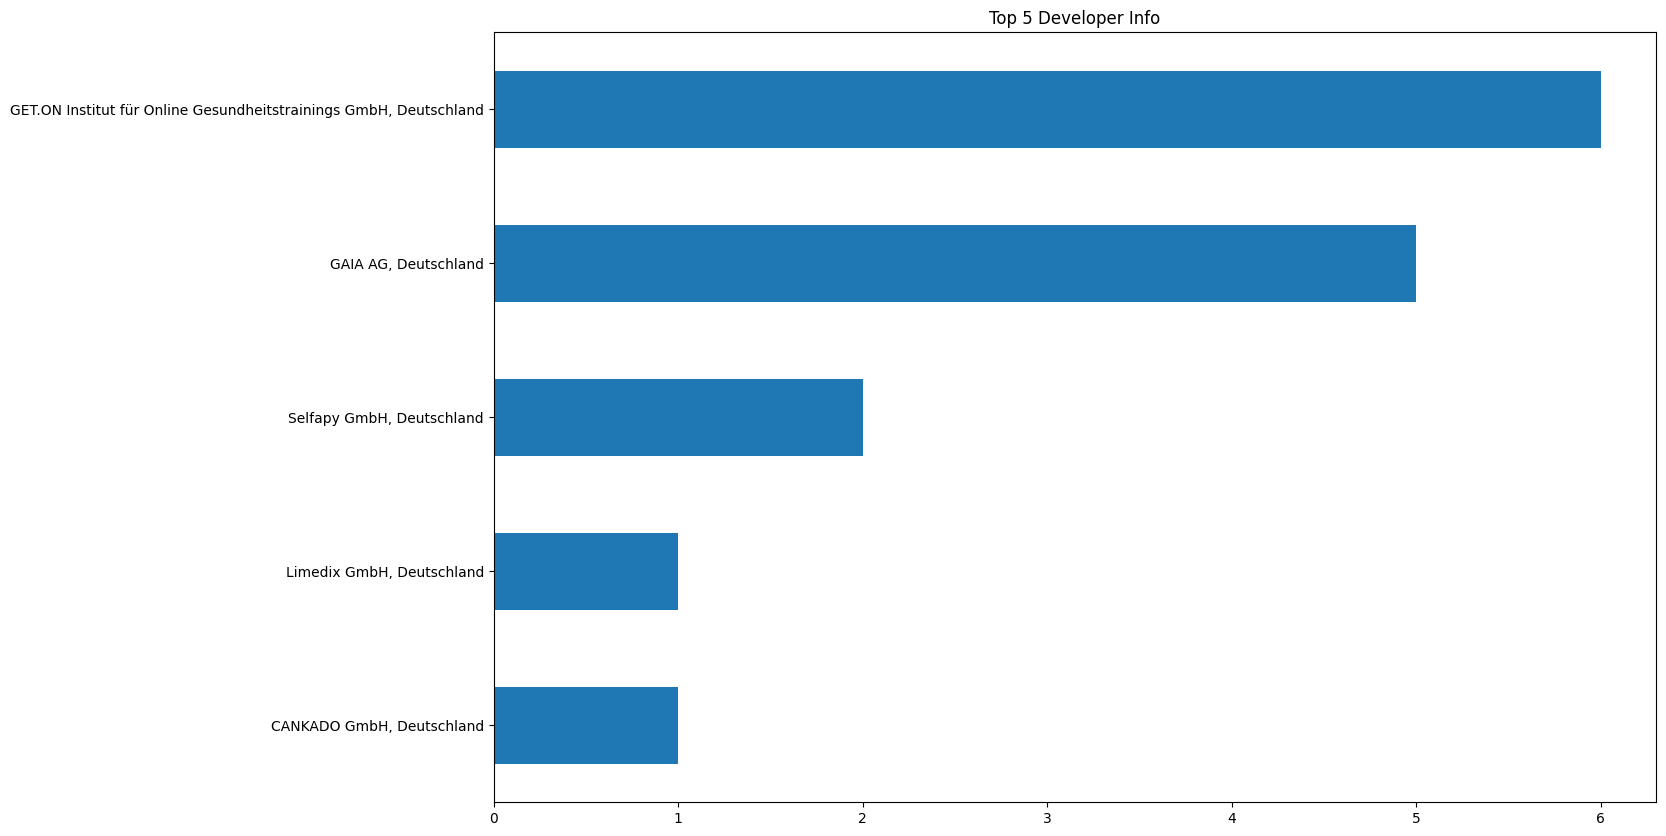

In [5]:
df['developer_info'].value_counts().head(5).sort_values(ascending=True).plot(kind='barh', figsize=(15,10), title='Top 5 Developer Info');

Number of apps with status "temporarily approved": 22
Number of apps with status "approved": 15


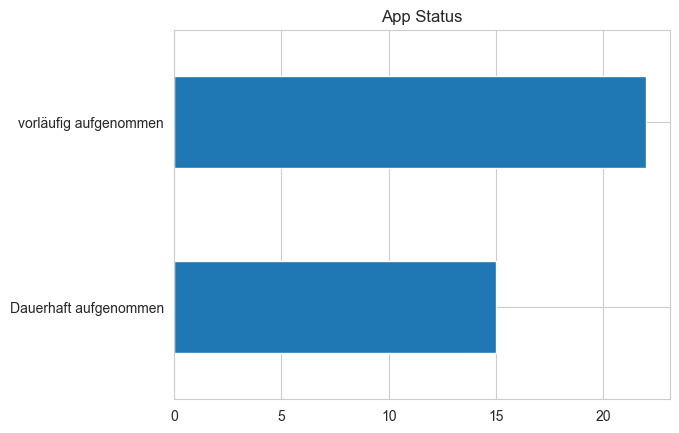

In [62]:
# visualize the total count of app statuses
print(f'Number of apps with status "temporarily approved": {len(df[df["app_status"] == "vorläufig aufgenommen"])}')
print(f'Number of apps with status "approved": {len(df[df["app_status"] == "Dauerhaft aufgenommen"])}')
df['app_status'].value_counts().sort_values(ascending=True).plot(kind='barh', title='App Status');

The average price = 435.95
Min = 119.0
Max = 952.0
Median = 449.0


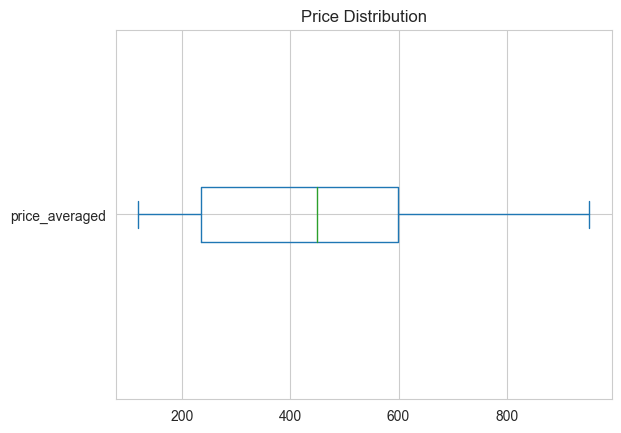

In [80]:
## visualize the average price of all apps
# convert price to float
# if df['price'] contains -, calculate the mean by taking the average of the two numbers
df['price_averaged'] = df['price'].str.replace(' ', '')
df['price_averaged'] = df['price_averaged'].str.replace('-', ' ')
df['price_averaged'] = df['price_averaged'].str.split(' ')
df['price_averaged'] = df['price_averaged'].apply(lambda x: (float(x[0]) + float(x[1]))/2 if len(x) > 1 else float(x[0]))
# print the average price with 2 decimal places
print(f'The average price = {df["price_averaged"].mean().round(2)}')
# calcuated the min and max price
print(f'Min = {df["price_averaged"].min()}')
print(f'Max = {df["price_averaged"].max()}')
print(f'Median = {df["price_averaged"].median()}')
# visualize a boxplot of the prices (middle line is the median)
df['price_averaged'].plot(kind='box', vert=False, title='Price Distribution');

## Indication Code (ICD) 
- “International Statistical Classification of Diseases and Related Health Problems”.
- a global system for consistently labeling of medical diagnoses
- diagnosis / prescription must contain an ICD!

In [81]:
# select all individual indication codes
indication_codes = df['indication_codes'].str.split(',').tolist()
counts = [len(sublist) for sublist in indication_codes]


indication_codes = [item for sublist in indication_codes for item in sublist]
# remove empty spaces
indication_codes = [x.strip() for x in indication_codes]
# remove duplicates
indication_codes_unique = list(set(indication_codes))
# print the total number of indication codes
print(f'The total number of covered indications is: {len(indication_codes)} unique indications')

The total number of covered indications is: 112 unique indications


In [64]:
# draw a wordcloud
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

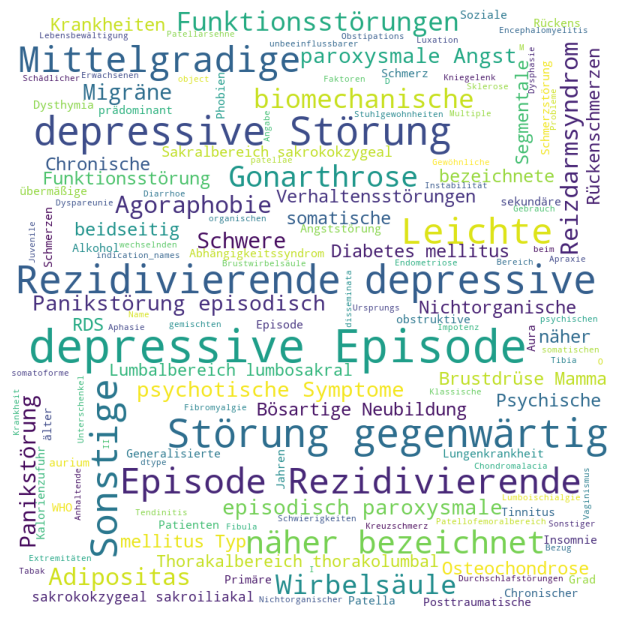

In [65]:
from wordcloud import WordCloud

stopwords = stopwords.words('german')

wordcloud = WordCloud(stopwords=stopwords, width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(str(df['indication_names']))
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [66]:
indications_text_full = df['indication_names'].values
indications_text_full = [i for i in indications_text_full]
# translate df['indication_names'] into english
# tokenize the text
tokenized_text = tokenizer(indications_text_full, padding=True, truncation=True, return_tensors="pt")

#translate the text
translated_text = model.generate(**tokenized_text, num_beams=4, early_stopping=True, max_length=512)

# decode the text
translated_text_full = tokenizer.batch_decode(translated_text, skip_special_tokens=True)
translated_text = ','.join(translated_text_full)
# add the translated text to the dataframe
df['indication_names_translated'] = translated_text_full
app_description = df['app_description'].values
app_description = [i for i in app_description]


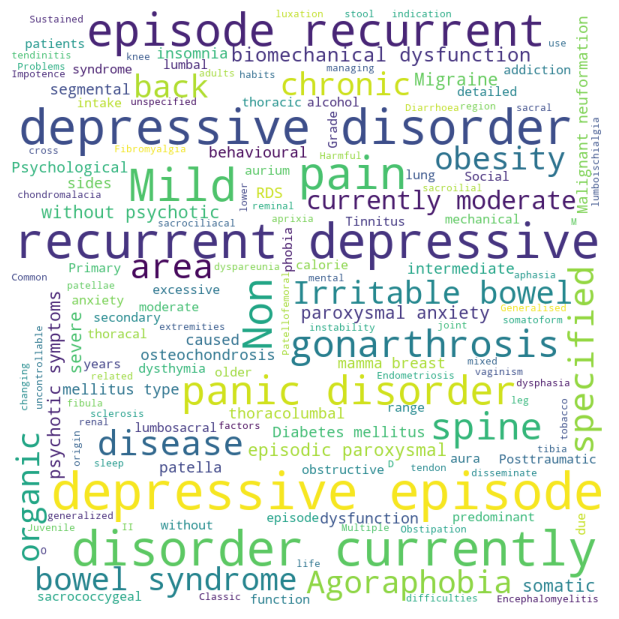

In [67]:
# create wordcloud on decoded_text2
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(translated_text)
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [35]:
df = pd.read_csv('diga_translated.csv')
# take each row with app_name, developer_info, indication_codes, indication_names, app_description
df_ger = df[['indication_names']]

# create a dictionary with row index as key and all the other columns as values as a single value
df_dict = df_ger.T.to_dict('list')
# do the same with the english version
df_en = df [['indication_names_translated']]

# create a dictionary with row index as key and all the other columns as values as a single value
df_dict_en = df_en.T.to_dict('list')

indication_names_eng = list(df_en['indication_names_translated'].values)
indication_names_ger = list(df_ger['indication_names'].values)

ind_eng = [i.split(',') for i in indication_names_eng]
ind_ger = [i.split(',') for i in indication_names_ger]
ind_eng = [item for sublist in ind_eng for item in sublist]
ind_ger = [item for sublist in ind_ger for item in sublist]
ind_eng = [x.strip() for x in ind_eng]
ind_ger = [x.strip() for x in ind_ger]
ind_eng = list(set(ind_eng))
ind_ger = list(set(ind_ger))

In [55]:
"""
This is a simple application for sentence embeddings: clustering

Sentences are mapped to sentence embeddings and then agglomerative clustering with a threshold is applied.
"""
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
import numpy as np

embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Corpus with example sentences
corpus = ind_eng
corpus_embeddings = embedder.encode(corpus)

# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

# Perform kmean clustering
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5) #, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(corpus[sentence_id])
# create an empty dataframe with columns 'cluster id' and 'indication names'
df_cluster = pd.DataFrame(columns=['cluster id', 'indication names'])
for i, cluster in clustered_sentences.items():
    df_cluster = df_cluster.append({'cluster id': i, 'indication names': cluster}, ignore_index=True)

# sort the df_cluster by the cluster id, drop the index and set cluster id as index
df_cluster = df_cluster.sort_values(by='cluster id').reset_index(drop=True).set_index('cluster id')
# show the dataframe df_cluster in a table format


In [79]:
# show the dataframe df_cluster full width
pd.set_option('display.max_colwidth', None)
# unset the full width

print(f'Total number of clusters: {len(df_cluster)} with AgglomerativeClustering')
print('----------------------------------------------------------')
df_cluster

Total number of clusters: 23 with AgglomerativeClustering
----------------------------------------------------------


,indication names
cluster id,
0,"[generalized anxiety disorder, Social phobias, panic disorder episodic paroxysmal anxiety, Agoraphobia, Generalised anxiety disorder, Agoraphobia: Without indication of panic disorder, Agoraphobia: With panic disorder, social phobia]"
1,"[currently moderate episode, currently mild episode, intermediate depressive episode, Mild depressive episode, currently severe episode without psychotic symptoms, recurrent depressive disorder, moderate depressive episode, severe depressive episode without psychotic symptoms]"
2,"[dysphasia and aphasia, Malignant neuformation of the mamma breast, Multiple sclerosis Encephalomyelitis disseminate, Problems related to difficulties in managing life]"
3,"[Obstipation-predominant RDS-O, Irritable bowel syndrome with changing (mixed) stool habits RDS-M, Irritable bowel syndrome, Other and unspecified Irritable bowel syndrome, Diarrhoea-predominant RDS-D]"
4,"[knee joint, lumboischialgia, pain in extremities: lower leg fibula, Endometriosis, Fibromyalgia]"
5,"[segmental and somatic dysfunctions: lumbal area lumbosacral, other biomechanical dysfunctions: thoracal range thoracolumbal, other biomechanical dysfunctions: lumbal area lumbosacral, biomechanical dysfunction, pain in the area of the thoracic spine, segmental and somatic dysfunctions: thoracic area thoracolumbal, not specified: thoracal range thoracolumbal]"
6,"[sacrociliacal, sacroilial, segmental and somatic dysfunctions: sacral area sacrococcygeal, other biomechanical dysfunctions: sacrococcygeal]"
7,"[Primary gonarthrosis, gonarthrosis, Other primary gonarthrosis, Posttraumatic gonarthrosis, Other secondary gonarthrosis, Other posttraumatic gonarthrosis]"
8,"[Chronic uncontrollable pain, Other chronic pain, Chronic pain disorder with somatic and psychological factors, cross pain, Sustained somatoform pain disorder]"


In [53]:
# reduce each entry in the corpus to three words maximum
corpus_reduced = [i.split(' ')[:3] for i in corpus]
# join the words with a space
corpus_reduced = [' '.join(i) for i in corpus_reduced]

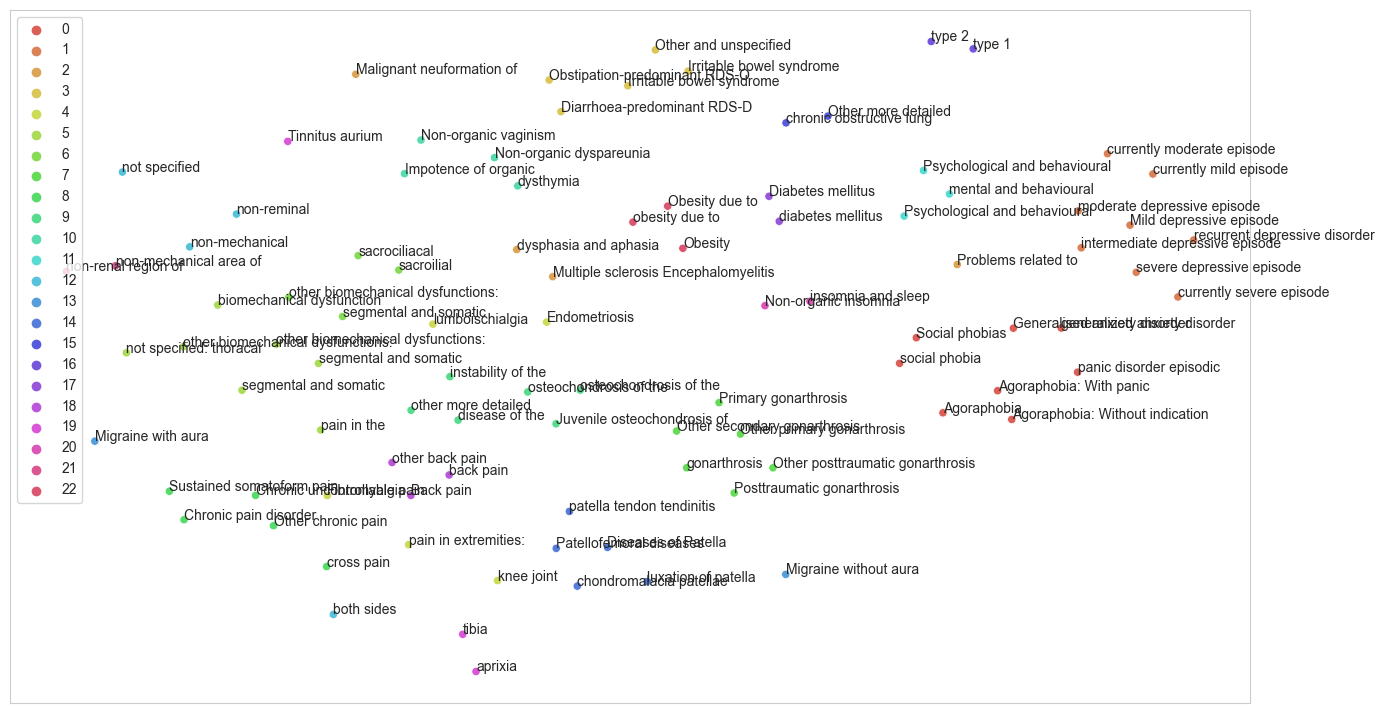

In [57]:
# visualize the clusters
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce it to two components with TSNE
X = TSNE(n_components=2).fit_transform(corpus_embeddings)

# Plot the solution
plt.figure(figsize=(16,9))
plt.xticks([])
plt.yticks([])

# Remove grid lines
plt.grid(visible=False)

ax = sns.scatterplot(x=X[:,0], y=X[:,1], hue=cluster_assignment, palette=sns.color_palette("hls", len(set(cluster_assignment))))
for i, txt in enumerate(corpus_reduced):

    ax.annotate(txt, (X[i,0], X[i,1]))

plt.show()

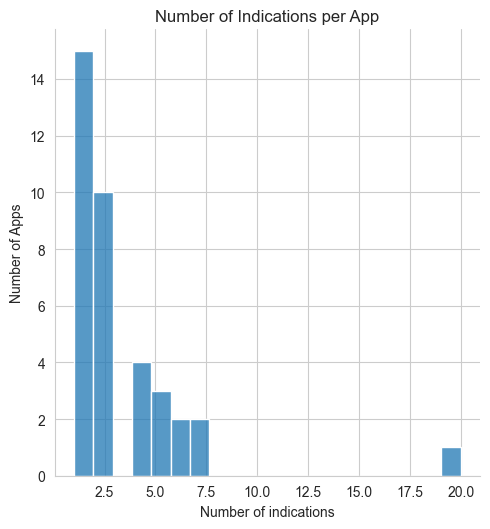

In [68]:
# visualize the distribution of the number of indication codes per app
sns.set_style("whitegrid")

# plot boxplot
gfg = sns.displot(data=counts, kde=False, rug=False, bins=20)

# add label to the axis and label to the plot
gfg.set(xlabel ="Number of indications", ylabel = "Number of Apps", title ='Number of Indications per App');


In [70]:
# select the app with the most indication codes
pd.reset_option('display.max_colwidth')
df[df['indication_codes'].str.split(',').str.len().max() == df['indication_codes'].str.split(',').str.len()]

,app_name,developer_info,website_info,app_status,start_date,end_date,app_description,indication_codes,indication_names,price,property_values,price_averaged,indication_names_translated,app_description_translated
34,Vivira,"Vivira Health Lab GmbH, Deutschland",www.vivira.com,Dauerhaft aufgenommen,NaN,NaN,Die DiGA Vivira ist eine durch das BfArM endgü...,"M42.0, M42.1, M42.9, M53.2, M53.8, M53.9, M54....","Juvenile Osteochondrose der Wirbelsäule, Osteo...",239.96,"Keine Zusatzgeräte, Vertragsärztliche Leistung...",239.96,"Juvenile osteochondrosis of the spine, osteoch...",The DiGA Vivira is a digital application for t...


In [14]:
indication_text_max = df[df['indication_codes'].str.split(',').str.len().max() == df['indication_codes'].str.split(',').str.len()].indication_names.values
indication_text_max[0]

'Juvenile Osteochondrose der Wirbelsäule, Osteochondrose der Wirbelsäule beim Erwachsenen, Osteochondrose der Wirbelsäule, nicht näher bezeichnet, Instabilität der Wirbelsäule, Sonstige näher bezeichnete Krankheiten der Wirbelsäule und des Rückens, Krankheit der Wirbelsäule und des Rückens, nicht näher bezeichnet, Lumboischialgie, Kreuzschmerz, Schmerzen im Bereich der Brustwirbelsäule, Sonstige Rückenschmerzen, Rückenschmerzen, nicht näher bezeichnet, Segmentale und somatische Funktionsstörungen: Thorakalbereich thorakolumbal, Segmentale und somatische Funktionsstörungen: Lumbalbereich lumbosakral, Segmentale und somatische Funktionsstörungen: Sakralbereich sakrokokzygeal, sakroiliakal, Sonstige biomechanische Funktionsstörungen: Thorakalbereich thorakolumbal, Sonstige biomechanische Funktionsstörungen: Lumbalbereich lumbosakral, Sonstige biomechanische Funktionsstörungen: Sakralbereich sakrokokzygeal, sakroiliakal, Biomechanische Funktionsstörung, nicht näher bezeichnet: Thorakalbere

In [17]:
max_indications_list = [i for i in indication_text_max[0].split(',')]
# tokenize the text
tokenized_text = tokenizer(max_indications_list, padding=True, truncation=True, return_tensors="pt")

#translate the text
translated_text = model.generate(**tokenized_text)

# decode the text
translated_text = tokenizer.batch_decode(translated_text, skip_special_tokens=True)

print(translated_text)

['Juvenile osteochondrosis of the spine', 'Osteochondrosis of the spine in adults', 'Osteochondrosis of the spine', 'Not specified', 'Instability of the spine', 'Other more detailed diseases of the spine and back', 'Disease of the spine and back', 'Not specified', 'Lumboischialgia', 'Cross pain', 'Chest vertebra pain', 'Other back pain', 'Back pain', 'Not specified', 'Segmental and somatic dysfunction: thoracal range thorakolumbal', 'Segmental and somatic dysfunction: Lumbal area lumbosacral', 'Segmental and somatic dysfunctions: sacral area sacrococzygeal', 'sacroiliakal', 'Other biomechanical dysfunctions: thoracal range thoracolumbal', 'Other biomechanical dysfunctions: Lumbal area lumbosacral', 'Other biomechanical dysfunctions: sacral area sacrococcygeal', 'sacroiliakal', 'Biomechanical dysfunction', 'not specified: thoracal range thorakolumbal', 'Biomechanical dysfunction', 'not specified: Lumbal area lumbosacral', 'Biomechanical dysfunction', 'not specified: sacral area sacrococ

In [25]:
# count the values of the indication codes
indication_codes = df['indication_codes'].str.split(',').tolist()
indication_codes = [item for sublist in indication_codes for item in sublist]
# remove empty spaces
indication_codes = [x.strip() for x in indication_codes]
# count the number of occurences of each indication code
from collections import Counter
indication_codes_count = Counter(indication_codes)
indication_codes_count

# select the top 10 indication codes 
top5 = indication_codes_count.most_common(5)

In [26]:
most_wanted_indications = []
for i in top5:
    i = i[0]
    # select the first app with the indication code
    app = df[df['indication_codes'].str.contains(i)].iloc[0]
    # find the index of the indication code
    index = [x.strip() for x in app['indication_codes'].split(',')].index(i)
    # find the indication_names for the indication code
    indication_name = app['indication_names'].split(',')[index]
    # add the indication name to the a list 
    most_wanted_indications.append(indication_name)
print(f'the top 5 most wanted indications are: \n{most_wanted_indications}')

the top 5 most wanted indications are: 
['Leichte depressive Episode', ' Mittelgradige depressive Episode', ' Rezidivierende depressive Störung', ' gegenwärtig leichte Episode', ' Panikstörung episodisch paroxysmale Angst']


In [27]:

# tokenize the text
tokenized_text = tokenizer(most_wanted_indications, padding=True, truncation=True, return_tensors="pt")

#translate the text
translated_text = model.generate(**tokenized_text, max_length=100, num_beams=4, early_stopping=True)

# decode the text
most_wanted_indications_eng = tokenizer.batch_decode(translated_text, skip_special_tokens=True)

In [82]:
print(f'the top 5 most wanted indications:')
print(f'----------------------------------')
for i in range(len(most_wanted_indications_eng)):
    print(f'{most_wanted_indications_eng[i]} with a total of - {top5[i][1]} apps -')

the top 5 most wanted indications:
----------------------------------
Slightly depressive episode with a total of - 5 apps -
Middle Depressive Episode with a total of - 5 apps -
Recurrent depressive disorder with a total of - 5 apps -
at present light episode with a total of - 5 apps -
Panic disorder Episodic paroxysmal anxiety with a total of - 4 apps -


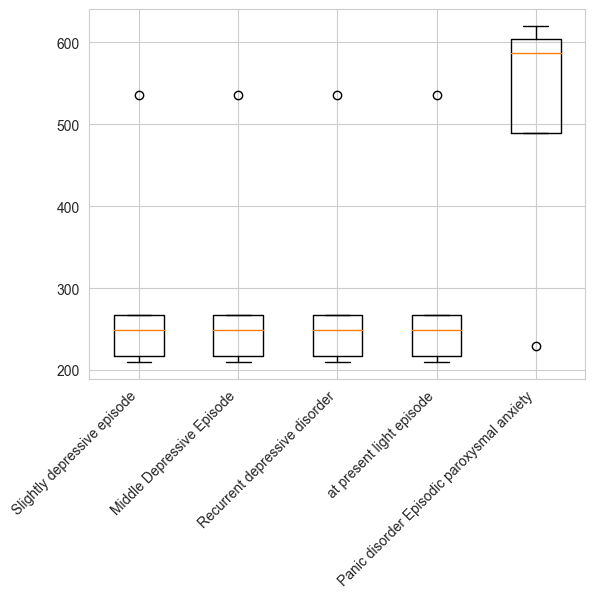

In [58]:
apps_list = []
for i in top5:
    i = i[0]
    # select the first app with the indication code
    apps = df[df['indication_codes'].str.contains(i)]
    # add the apps to the list
    apps_list.append([apps['price_averaged']])

# get the values of a series apps_list[0][0]
apps_cost = [i[0].values for i in apps_list]
# visualize a list of boxplots
fig, ax = plt.subplots()
# 
bp = ax.boxplot(apps_cost)
ax.set_xticklabels(most_wanted_indications_eng, rotation=45, ha='right')
plt.show()



In [72]:
print('Outlier prices for the top 5 indications')
print('----------------------------------------')
for outlier_path in bp['fliers']:
    outlier_data = outlier_path.get_data()[1]
    name = df[df['price_averaged'] == outlier_data[0]].app_name.values
    print(outlier_data, name)

Outlier prices for the top 5 indications
----------------------------------------
[535.49] ['elona therapy Depression']
[535.49] ['elona therapy Depression']
[535.49] ['elona therapy Depression']
[535.49] ['elona therapy Depression']
[230.] ['velibra']


In [30]:
df[df['app_name'] == 'elona therapy Depression']

,app_name,developer_info,website_info,app_status,start_date,end_date,app_description,indication_codes,indication_names,price,property_values,price_averaged,indication_names_translated
6,elona therapy Depression,"Elona Health GmbH, Deutschland",www.elona.health,vorläufig aufgenommen,26.12.2022,25.12.2023,elona therapy Depression ist die digitale Gesu...,"F32.0, F32.1, F32.2, F33.0, F33.1, F33.2, F34.1","Leichte depressive Episode, Mittelgradige depr...",535.49,"Keine Zusatzgeräte, Vertragsärztliche Leistung...",535.49,"Mild depressive episode, moderate depressive e..."


In [31]:
df[df['app_name'] == 'velibra']

,app_name,developer_info,website_info,app_status,start_date,end_date,app_description,indication_codes,indication_names,price,property_values,price_averaged,indication_names_translated
32,velibra,"GAIA AG, Deutschland",gaia-group.com/de/,Dauerhaft aufgenommen,NaN,NaN,velibra ist ein webbasiertes Programm für Pati...,"F40.01, F40.1, F41.0, F41.1","Agoraphobie: Mit Panikstörung, Soziale Phobien...",230.00,"Keine Zusatzgeräte, Keine vertragsärztlichen L...",230.0,"Agoraphobia: With panic disorder, social phobi..."


In [73]:
# lowest price for the top1 indication code
indication1 = top5[0][0]
# choose the app with the highest price for the indication
sorted_df = df[df['indication_codes'].str.contains(indication1)].sort_values(by='price_averaged', ascending=True)
# show only the first, fourth and last column
print('App prices for the top 1 indication code')
print('----------------------------------------')
sorted_df[['app_name', 'app_status', 'price_averaged', 'indication_codes']]

App prices for the top 1 indication code
----------------------------------------


,app_name,app_status,price_averaged,indication_codes
3,deprexis,Dauerhaft aufgenommen,210.00,"F32.0, F32.1, F32.2, F33.0, F33.1, F33.2"
28,Selfapys Online-Kurs bei Depression,Dauerhaft aufgenommen,217.18,"F32.0, F32.1, F33.0, F33.1"
23,Novego: Depressionen bewältigen,vorläufig aufgenommen,249.00,"F32.0, F32.1, F33.0, F33.1, F34.1"
4,edupression.com®,vorläufig aufgenommen,267.75,"F32.0, F32.1, F33.0, F33.1"
6,elona therapy Depression,vorläufig aufgenommen,535.49,"F32.0, F32.1, F32.2, F33.0, F33.1, F33.2, F34.1"
